In [1]:
import math
from numpy import linalg as LA
import sympy as sp
import numpy as np
import random
from numba import njit, prange, cuda

def convert(o):
    if isinstance(o, np.int64): return int(o)
    raise TypeError


def fFeim(x, pole, resi, sigma=1):
    return 1 / 2 - sigma * sum(2.0 * resi[i] * x / (x**2 + pole[i]**2)
                               for i in range(len(pole)))


def tseig(D, E):
    mat = np.diag(E, -1) + np.diag(D, 0) + np.diag(E, 1)
    return -np.sort(-np.linalg.eigvalsh(mat))


def MSD(N, BoseFermi=2):
    if BoseFermi == 1:
        pole = np.array([2 * (i + 1) * np.pi for i in range(N)])
        resi = np.ones(N, dtype=float)
        return pole, resi
    elif BoseFermi == 2:
        pole = np.array([(2 * i + 1) * np.pi for i in range(N)])
        resi = np.ones(N, dtype=float)
        return pole, resi


def PSD(N, BoseFermi=2, pade=0):
    if N < 0 or BoseFermi < 1 or BoseFermi > 2 or pade < 0 or pade > 3:
        raise ValueError("N or BoseFermi or pade has wrong value!")

    if pade == 0:
        return MSD(N, BoseFermi)
    elif pade == 1 or pade == 2:
        pole, resi = [], []
        if N > 0:
            M = 2 * N + pade // 2
            temp = 3.0 if BoseFermi == 1 else 1.0
            diag = np.zeros(M, dtype=float)
            doff = np.array([
                1.0 / math.sqrt((temp + 2.0 * i) * (temp + 2.0 * (i + 1)))
                for i in range(M - 1)
            ])
            pole = 2.0 / tseig(diag, doff)[:N]
            pol2 = np.array([x * x for x in pole])
            M -= 1
            temp = 5.0 if BoseFermi == 1 else 3.0
            diag = np.zeros(M, dtype=float)
            doff = np.array([
                1.0 / math.sqrt((temp + 2.0 * i) * (temp + 2.0 * (i + 1)))
                for i in range(M - 1)
            ])
            M //= 2
            eig2 = np.power(2.0 / tseig(diag, doff)[:M], 2)
            print(eig2)

            scaling = 0.0
            if BoseFermi == 1:
                scaling = N*(2.0*N+3.0) if pade == 1 else 1.0 / \
                    (4.0*(N+1.0)*(2.0*N+3.0))
            elif BoseFermi == 2:
                scaling = N*(2.0*N+1.0) if pade == 1 else 1.0 / \
                    (4.0*(N+1.0)*(2.0*N+1.0))
            resi = np.zeros(N, dtype=float)
            for j in range(N):
                if pade == 2:
                    temp = 0.5 * scaling * (eig2[j] - pol2[j])
                elif pade == 1:
                    if j == N - 1:
                        temp = 0.5 * scaling
                    else:
                        temp = 0.5*scaling * \
                            (eig2[j]-pol2[j])/(pol2[N-1]-pol2[j])
                for k in range(M):
                    temp *= (eig2[k]-pol2[j]) / \
                        (pol2[k]-pol2[j]) if k != j else 1.0
                resi[j] = temp
        rn, tn = 0.0, 0.0
        if BoseFermi == 1 and pade == 2:
            rn = 1.0 / (4.0 * (N + 1.0) * (2.0 * N + 3.0))
        return pole, resi
    elif pade == 3:
        Np1 = N + 1
        temp = 3.0 if BoseFermi == 1 else 1.0
        d = np.empty(2 * Np1, dtype=float)
        d[0] = 0.25 / temp
        d[-1] = -4.0 * (N + 1.0) * (N + 1.0) * (temp + 2 * N) * (
            temp + 2 * N) * (temp + 4 * N + 2.0)
        for i in range(1, Np1):
            d[2*i-1] = -4.0*i*i*(temp+2.0*i-2.0) * \
                (temp+2.0*i-2.0)*(temp+4.0*i-2.0)
            d[2 * i] = -0.25 * (temp + 4.0 * i) / i / (i + 1) / (
                temp + 2.0 * i - 2.0) / (temp + 2.0 * i)
        sumd2 = np.empty(Np1, dtype=float)
        sumd2[0] = d[1]
        for i in range(1, Np1):
            sumd2[i] = sumd2[i - 1] + d[2 * i + 1]
        tn = 0.25 / sumd2[-1]
        rn = sum(d[2 * i] * (4.0 * tn *
                             (sumd2[-1] - sumd2[i - 1]))**2 if i > 0 else d[2 *
                                                                            i]
                 for i in range(Np1))
        M = 2 * N + 1
        diag = np.zeros(M, dtype=float)
        doff = np.array(
            [1.0 / math.sqrt(d[i + 1] * d[i + 2]) for i in range(M - 1)])
        pole = 2.0 / tseig(diag, doff)[:N]
        resi = np.zeros(N, dtype=float)
        for j in range(N):
            scaling = pole[j] * pole[j]
            r0, t1 = 0.0, 0.25 / d[1]
            eta0, eta1, eta2 = 0.0, 0.5, 0.0
            for i in range(Np1):
                r1 = t1 if (i == j
                            or i == N) else t1 / (pole[i] * pole[i] - scaling)
                r2 = 2.0*math.sqrt(abs(r1)) if r1 > 0 else - \
                    2.0*math.sqrt(abs(r1))
                r1 = 2.0 * math.sqrt(abs(r1))
                eta2 = d[2 * i] * r1 * eta1 - 0.25 * r1 * r0 * scaling * eta0
                eta0 = eta1
                eta1 = eta2
                eta2 = d[2 * i +
                         1] * r2 * eta1 - 0.25 * r2 * r1 * scaling * eta0
                eta0 = eta1
                eta1 = eta2
                r0 = r2
                if i != N:
                    t1 = sumd2[i] / sumd2[i + 1]
            resi[j] = eta2
        return pole, resi


def arma_print(ndarray):

    shape = ndarray.shape
    dimen = len(shape)

    if dimen == 1:

        if issubclass(type(ndarray[0]), np.int_):
            print('ARMA_MAT_TXT_IS004\n%d %d' % (shape[0], 1))
            for row in ndarray:
                print('%d' % row)
        elif issubclass(type(ndarray[0]), float):
            print('ARMA_MAT_TXT_FN008\n%d %d' % (shape[0], 1))
            for row in ndarray:
                print('%.8e' % row)
        elif issubclass(type(ndarray[0]), complex):
            print('ARMA_MAT_TXT_FC016\n%d %d' % (shape[0], 1))
            for row in ndarray:
                print('(%.8e,%-.8e)' % (row.real, row.imag))

    elif dimen == 2:

        if issubclass(type(ndarray[0, 0]), np.int_):
            print('ARMA_MAT_TXT_IS004\n%d %d' % (shape[0], shape[1]))
            for row in ndarray:
                print(' '.join('%d' % x for x in row))
        elif issubclass(type(ndarray[0, 0]), float):
            print('ARMA_MAT_TXT_FN008\n%d %d' % (shape[0], shape[1]))
            for row in ndarray:
                print(' '.join('%.8e' % x for x in row))
        elif issubclass(type(ndarray[0, 0]), complex):
            print('ARMA_MAT_TXT_FC016\n%d %d' % (shape[0], shape[1]))
            for row in ndarray:
                print(' '.join('(%.8e,%-.8e)' % (x.real, x.imag) for x in row))

    elif dimen == 3:

        if issubclass(type(ndarray[0, 0, 0]), np.int_):
            print('ARMA_CUB_TXT_IS004\n%d %d %d' %
                  (shape[1], shape[2], shape[0]))
            for slc in ndarray:
                for row in slc:
                    print(' '.join('%d' % x for x in row))
        elif issubclass(type(ndarray[0, 0, 0]), float):
            print('ARMA_CUB_TXT_FN008\n%d %d %d' %
                  (shape[1], shape[2], shape[0]))
            for slc in ndarray:
                for row in slc:
                    print(' '.join('%-.8e' % x for x in row))
        elif issubclass(type(ndarray[0, 0, 0]), complex):
            print('ARMA_CUB_TXT_FC016\n%d %d %d' %
                  (shape[1], shape[2], shape[0]))
            for slc in ndarray:
                for row in slc:
                    print(' '.join('(%.8e,%-.8e)' % (x.real, x.imag)
                                   for x in row))


def arma_write(ndarray, filename):

    shape = ndarray.shape
    dimen = len(shape)

    with open(filename, 'w') as f:
        if dimen == 1:
            if issubclass(type(ndarray[0]), np.int_):
                print('ARMA_MAT_TXT_IS004\n%d %d' % (shape[0], 1), file=f)
                for row in ndarray:
                    print('%d' % row, file=f)
            elif issubclass(type(ndarray[0]), float):
                print('ARMA_MAT_TXT_FN008\n%d %d' % (shape[0], 1), file=f)
                for row in ndarray:
                    print('%.8e' % row, file=f)
            elif issubclass(type(ndarray[0]), complex):
                print('ARMA_MAT_TXT_FC016\n%d %d' % (shape[0], 1), file=f)
                for row in ndarray:
                    print('(%.8e,%-.8e)' % (row.real, row.imag), file=f)

        elif dimen == 2:

            if issubclass(type(ndarray[0, 0]), np.int_):
                print('ARMA_MAT_TXT_IS004\n%d %d' % (shape[0], shape[1]),
                      file=f)
                for row in ndarray:
                    print(' '.join('%d' % x for x in row), file=f)
            elif issubclass(type(ndarray[0, 0]), float):
                print('ARMA_MAT_TXT_FN008\n%d %d' % (shape[0], shape[1]),
                      file=f)
                for row in ndarray:
                    print(' '.join('%.8e' % x for x in row), file=f)
            elif issubclass(type(ndarray[0, 0]), complex):
                print('ARMA_MAT_TXT_FC016\n%d %d' % (shape[0], shape[1]),
                      file=f)
                for row in ndarray:
                    print(' '.join('(%.8e,%-.8e)' % (x.real, x.imag)
                                   for x in row),
                          file=f)

        elif dimen == 3:

            if issubclass(type(ndarray[0, 0, 0]), np.int_):
                print('ARMA_CUB_TXT_IS004\n%d %d %d' %
                      (shape[1], shape[2], shape[0]),
                      file=f)
                for slc in ndarray:
                    for row in slc:
                        print(' '.join('%d' % x for x in row))
            elif issubclass(type(ndarray[0, 0, 0]), float):
                print('ARMA_CUB_TXT_FN008\n%d %d %d' %
                      (shape[1], shape[2], shape[0]),
                      file=f)
                for slc in ndarray:
                    for row in slc:
                        print(' '.join('%-.8e' % x for x in row), file=f)
            elif issubclass(type(ndarray[0, 0, 0]), complex):
                print('ARMA_CUB_TXT_FC016\n%d %d %d' %
                      (shape[1], shape[2], shape[0]),
                      file=f)
                for slc in ndarray:
                    for row in slc:
                        print(' '.join('(%.8e,%-.8e)' % (x.real, x.imag)
                                       for x in row),
                              file=f)


# in this script, we can decompose any given spectrum, but the sympy format is must been given
# do u like haskell?
# sympy[spe(def by sympy)], dict[sp_para_dict], dict[para_dict], dict[npsd],
# dict[pade] >> np.array[etal], np.array[etar],np.array[etaa], np.array[expn]


def decompose_spe(spe,
                  sp_para_dict,
                  para_dict,
                  condition_dict,
                  npsd,
                  sigma,
                  pade=1):
    numer, denom = sp.cancel(sp.factor(
        spe.subs(condition_dict))).as_numer_denom()
    numer_get_para = (sp.factor(numer)).subs(sp_para_dict)
    denom_get_para = (sp.factor(denom)).subs(sp_para_dict)
    poles = sp.nroots(denom_get_para)
    float(sp.re(poles[0]))

    print(poles)

    expn = []
    poles_allplane = np.array([])
    for i in poles:
        i = complex(i)
        if i.imag * sigma > 0:
            expn.append(-sigma * i * 1.J)
        poles_allplane = np.append(poles_allplane, i)

    etal = []
    etar = []
    etaa = []

    expn = np.array(expn)

    expn_imag_sort = np.argsort(np.abs(np.imag(expn)))[::-1]
    expn_imag = np.sort(np.abs(np.imag(expn)))[::-1]

    expn_val_cc = []
    # expn_arg_cc = expn_imag_sort[expn_imag != 0]
    expn_val_n_cc = expn
    # expn_arg_n_cc = expn_imag_sort[expn_imag == 0]

    expn = list(expn[expn_imag_sort])
    pole, resi = PSD(npsd, 2, 1)
    beta = para_dict['beta']
    temp = 1 / beta

    for ii in range(len(expn_val_n_cc)):
        etal.append(
            complex(
                sp.N((sigma * 2.j * numer_get_para / np.multiply.reduce(
                    w_sp - poles_allplane[np.abs(poles_allplane - sigma * 1.J *
                                                 expn_val_n_cc[ii]) > 1e-14])
                      ).subs({w_sp: sigma * 1.j * expn_val_n_cc[ii]}) *
                     fFeim(sigma * 1.J * expn_val_n_cc[ii] / temp, pole, resi,
                           sigma))))
        etar.append(np.conj(etal[-1]))
        etaa.append(np.sqrt(np.abs(etal[-1]) * np.abs(etar[-1])))

    f = numer_get_para / np.multiply.reduce(w_sp - poles_allplane)
    f = sp.lambdify(w_sp, f)

    for inma in range(len(pole)):
        print(pole[inma])
        zomg = sigma * 1.J * pole[inma] * temp
        jsum = np.sum(f(zomg))
        expn.append(pole[inma] * temp)
        etal.append(-2.J * resi[inma] * temp * jsum)
        etar.append(np.conj(etal[-1]))
        etaa.append(np.abs(etal[-1]))

    etal = np.array(etal)
    etar = np.array(etar)
    etaa = np.array(etaa)
    expn = np.array(expn)

    return etal, etar, etaa, expn


def decompose_spe_real(spe,
                       sp_para_dict,
                       para_dict,
                       condition_dict,
                       sigma,
                       pade=1):
    numer, denom = sp.cancel(sp.factor(
        spe.subs(condition_dict))).as_numer_denom()
    numer_get_para = (sp.factor(numer)).subs(sp_para_dict)
    denom_get_para = (sp.factor(denom)).subs(sp_para_dict)
    poles = sp.nroots(denom_get_para)
    float(sp.re(poles[0]))

    print(poles)

    expn = []
    poles_allplane = np.array([])
    for i in poles:
        i = complex(i)
        if i.imag * sigma > 0:
            expn.append(-sigma * i * 1.J)
        poles_allplane = np.append(poles_allplane, i)

    etal = []
    etar = []
    etaa = []
    expn = np.array(expn)
    expn_imag_sort = np.argsort(np.abs(np.imag(expn)))[::-1]
    expn_imag = np.sort(np.abs(np.imag(expn)))[::-1]
    expn_val_cc = []
    expn_val_n_cc = expn
    expn = list(expn[expn_imag_sort])

    for ii in range(len(expn_val_n_cc)):
        etal.append(
            complex(
                sp.N((sigma * 1.j * numer_get_para /
                      np.multiply.reduce(w_sp - poles_allplane[np.abs(
                          poles_allplane -
                          sigma * 1.J * expn_val_n_cc[ii]) > 1e-14])).subs(
                              {w_sp: sigma * 1.j * expn_val_n_cc[ii]}))))
        etar.append(np.conj(etal[-1]))
        etaa.append(np.sqrt(np.abs(etal[-1]) * np.abs(etar[-1])))

    etal = np.array(etal)
    etar = np.array(etar)
    etaa = np.array(etaa)
    expn = np.array(expn)

    return etal, etar, etaa, expn


@njit()
def fit_J(w, res, expn, etal, sigma):
    for i in range(len(etal)):
        res += etal[i] / (expn[i] + sigma * 1.j * w)


def fit_t(t, res, expn, etal):
    for i in range(len(etal)):
        res += etal[i] * np.exp(-expn[i] * t)
    return res


def fit_t_d1(t, res, expn, etal):
    for i in range(len(etal)):
        res += -expn[i] * etal[i] * np.exp(-expn[i] * t)
    return res


def INDEX3(i, j, k, mum):
    return mum * mum * i + mum * j + k


def fit_prony(phixx, n, error):
    n_sample = n + 1
    h = phixx
    H = np.zeros((n_sample, n_sample))
    for i in range(n_sample):
        H[i, :] = h[i:n_sample + i]
    sing_vs, Q = LA.eigh(H)
    phase_mat = np.diag(
        [np.exp(-1j * np.angle(sing_v) / 2.0) for sing_v in sing_vs])
    vs = np.array([np.abs(sing_v) for sing_v in sing_vs])
    Qp = np.dot(Q, phase_mat)
    sort_array = np.argsort(vs)[::-1]
    vs = vs[sort_array]
    Qp = (Qp[:, sort_array])
    print(
        "error of decompose",
        np.sum(np.abs(H -
                      np.dot(np.dot(Qp, np.diag(vs)), (np.transpose(Qp))))))
    n_gamma = len(vs[vs > error]) + 1
    print("len of gamma", n_gamma)
    gamma = np.array([])
    for i in [n_gamma]:
        print(i)
        a = np.roots(Qp[:, i][::-1])
        gamma = np.append(gamma, a)
    gamma_new = gamma[np.argsort(np.abs(gamma))[:n_gamma]]
    t_new = 2 * n * np.log(gamma_new)

    plt.scatter(np.real(gamma), np.imag(gamma))
    plt.scatter(np.real(gamma_new), np.imag(gamma_new))
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1, 1)
    plt.show()
    gamma_m = np.zeros((n_sample * 2 - 1, n_gamma), dtype=complex)
    for i in range(n_gamma):
        for j in range(n_sample * 2 - 1):
            gamma_m[j, i] = gamma_new[i]**j
    omega_new = np.dot(LA.inv(np.dot(np.transpose(gamma_m), gamma_m)),
                       np.dot(np.transpose(gamma_m), np.transpose(h)))
    plt.scatter(np.real(omega_new), np.imag(omega_new))
    # plt.xlim(-0.15,0.15)
    # plt.ylim(-0.1,0.1)
    plt.show()
    return t_new, omega_new


def fit_prony_n(phixx, n, n_choose):
    n_sample = n + 1
    h = phixx
    H = np.zeros((n_sample, n_sample))
    for i in range(n_sample):
        H[i, :] = h[i:n_sample + i]
    sing_vs, Q = LA.eigh(H)
    phase_mat = np.diag(
        [np.exp(-1j * np.angle(sing_v) / 2.0) for sing_v in sing_vs])
    vs = np.array([np.abs(sing_v) for sing_v in sing_vs])
    Qp = np.dot(Q, phase_mat)
    sort_array = np.argsort(vs)[::-1]
    vs = vs[sort_array]
    Qp = (Qp[:, sort_array])
    print(
        "error of decompose",
        np.sum(np.abs(H -
                      np.dot(np.dot(Qp, np.diag(vs)), (np.transpose(Qp))))))
    n_gamma = n_choose
    print("len of gamma", n_gamma)
    gamma = np.array([])
    for i in [n_gamma]:
        a = np.roots(Qp[:, i][::-1])
        gamma = np.append(gamma, a)
    gamma_new = gamma[np.argsort(np.abs(gamma))[:n_gamma]]
    t_new = 2 * n * np.log(gamma_new)

    plt.scatter(np.real(gamma), np.imag(gamma))
    plt.scatter(np.real(gamma_new), np.imag(gamma_new))
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1, 1)
    plt.show()
    gamma_m = np.zeros((n_sample * 2 - 1, n_gamma), dtype=complex)
    for i in range(n_gamma):
        for j in range(n_sample * 2 - 1):
            gamma_m[j, i] = gamma_new[i]**j
    omega_new = np.dot(LA.inv(np.dot(np.transpose(gamma_m), gamma_m)),
                       np.dot(np.transpose(gamma_m), np.transpose(h)))
    plt.scatter(np.real(omega_new), np.imag(omega_new))
    # plt.xlim(-0.15,0.15)
    # plt.ylim(-0.1,0.1)
    plt.show()
    return t_new, omega_new

[-1.0*I, 1.0*I]
[ 39.47847339 159.99191554 570.52961106]
3.1415926536430856
9.426759654133644
16.606315470224267
46.31950868181952
[-1.0*I, 1.0*I]
[ 39.47847339 159.99191554 570.52961106]
3.1415926536430856
9.426759654133644
16.606315470224267
46.31950868181952


/home/dhem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: overflow encountered in exp
/home/dhem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: overflow encountered in exp


[-1.0*I, 1.0*I]
[   39.4784176    157.91367042   355.30576225   631.68089087
   993.44458417  1578.95512949  3204.13739509 12079.0841501 ]
3.141592653589794
9.424777960769374
15.707963268209335
21.991160273016472
28.284748883275093
35.12563780543594
46.343707071405156
74.16621992857758
218.24011524363982
[-1.0*I, 1.0*I]
[   39.4784176    157.91367042   355.30576225   631.68089087
   993.44458417  1578.95512949  3204.13739509 12079.0841501 ]
3.141592653589794
9.424777960769374
15.707963268209335
21.991160273016472
28.284748883275093
35.12563780543594
46.343707071405156
74.16621992857758
218.24011524363982
[-1.0*I, 1.0*I]
[3.94784176e+01 1.57913670e+02 3.55305758e+02 6.31654682e+02
 9.86960440e+02 1.42122326e+03 1.93455891e+03 2.53583053e+03
 3.34335371e+03 4.79579604e+03 8.00364386e+03 1.72570040e+04
 6.73472767e+04]
3.1415926535897936
9.424777960769369
15.70796326794898
21.991148575128555
28.274333882312707
34.5575192533683
40.84078430205396
47.137662457594864
53.811247757121464
62.807

/home/dhem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: overflow encountered in exp


[3.94784176e+01 1.57913670e+02 3.55305758e+02 6.31654682e+02
 9.86960440e+02 1.42122303e+03 1.93444246e+03 2.52661873e+03
 3.19775183e+03 3.94784176e+03 4.77688853e+03 5.68489214e+03
 6.67185258e+03 7.73776985e+03 8.88264396e+03 1.01064749e+04
 1.14092627e+04 1.27910073e+04 1.42517088e+04 1.57913670e+04
 1.74099822e+04 1.91075541e+04 2.08840829e+04 2.27395685e+04
 2.46740110e+04 2.66874103e+04 2.87797664e+04 3.09510794e+04
 3.32013492e+04 3.55305758e+04 3.79387593e+04 4.04258996e+04
 4.29919968e+04 4.56370508e+04 4.83610616e+04 5.11640292e+04
 5.40459537e+04 5.70068350e+04 6.00466732e+04 6.31654682e+04
 6.63632200e+04 6.96399287e+04 7.29955942e+04 7.64302165e+04
 7.99437956e+04 8.35363317e+04 8.72078245e+04 9.09582742e+04
 9.47876807e+04 9.86960440e+04 1.02683364e+05 1.06749641e+05
 1.10894875e+05 1.15119066e+05 1.19422213e+05 1.23804318e+05
 1.28265379e+05 1.32805397e+05 1.37424372e+05 1.42122303e+05
 1.46899192e+05 1.51755037e+05 1.56689839e+05 1.61703599e+05
 1.66796314e+05 1.719679

[3.94784176e+01 1.57913670e+02 3.55305758e+02 6.31654682e+02
 9.86960440e+02 1.42122303e+03 1.93444246e+03 2.52661873e+03
 3.19775183e+03 3.94784176e+03 4.77688853e+03 5.68489214e+03
 6.67185258e+03 7.73776985e+03 8.88264396e+03 1.01064749e+04
 1.14092627e+04 1.27910073e+04 1.42517088e+04 1.57913670e+04
 1.74099822e+04 1.91075541e+04 2.08840829e+04 2.27395685e+04
 2.46740110e+04 2.66874103e+04 2.87797664e+04 3.09510794e+04
 3.32013492e+04 3.55305758e+04 3.79387593e+04 4.04258996e+04
 4.29919968e+04 4.56370508e+04 4.83610616e+04 5.11640292e+04
 5.40459537e+04 5.70068350e+04 6.00466732e+04 6.31654682e+04
 6.63632200e+04 6.96399287e+04 7.29955942e+04 7.64302165e+04
 7.99437956e+04 8.35363317e+04 8.72078245e+04 9.09582742e+04
 9.47876807e+04 9.86960440e+04 1.02683364e+05 1.06749641e+05
 1.10894875e+05 1.15119066e+05 1.19422213e+05 1.23804318e+05
 1.28265379e+05 1.32805397e+05 1.37424372e+05 1.42122303e+05
 1.46899192e+05 1.51755037e+05 1.56689839e+05 1.61703599e+05
 1.66796314e+05 1.719679

/home/dhem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: overflow encountered in exp


{5: array([1.        +0.j, 0.03141593+0.j, 0.0942676 +0.j, 0.16606315+0.j,
        0.46319509+0.j]),
 10: array([1.        +0.j, 0.03141593+0.j, 0.09424778+0.j, 0.15707963+0.j,
        0.2199116 +0.j, 0.28284749+0.j, 0.35125638+0.j, 0.46343707+0.j,
        0.7416622 +0.j, 2.18240115+0.j]),
 15: array([1.        +0.j, 0.03141593+0.j, 0.09424778+0.j, 0.15707963+0.j,
        0.21991149+0.j, 0.28274334+0.j, 0.34557519+0.j, 0.40840784+0.j,
        0.47137662+0.j, 0.53811248+0.j, 0.62807644+0.j, 0.7779554 +0.j,
        1.06091974+0.j, 1.73892987+0.j, 5.17455785+0.j]),
 513: array([1.00000000e+00+0.j, 3.14159265e-02+0.j, 9.42477796e-02+0.j,
        1.57079633e-01+0.j, 2.19911486e-01+0.j, 2.82743339e-01+0.j,
        3.45575192e-01+0.j, 4.08407045e-01+0.j, 4.71238898e-01+0.j,
        5.34070751e-01+0.j, 5.96902604e-01+0.j, 6.59734457e-01+0.j,
        7.22566310e-01+0.j, 7.85398163e-01+0.j, 8.48230016e-01+0.j,
        9.11061870e-01+0.j, 9.73893723e-01+0.j, 1.03672558e+00+0.j,
        1.09955743

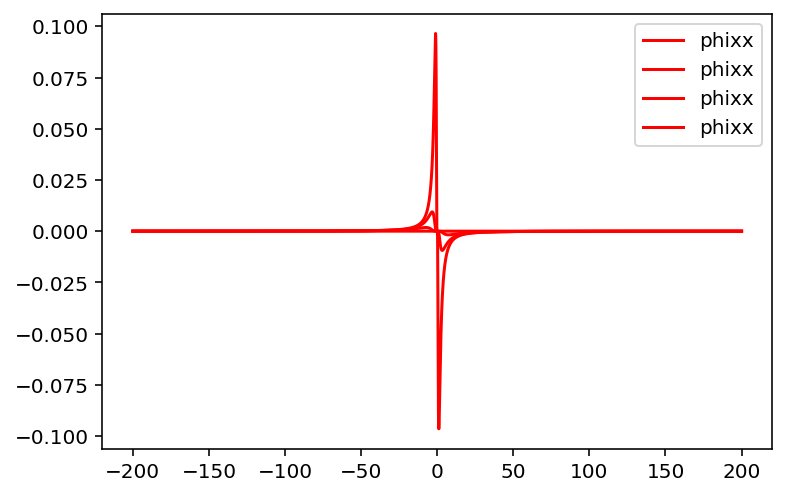

In [6]:
etal_pade_d = {}
expn_pade_d = {}

for npsd in [4, 9, 14, 512]:
    nmod = 4
    lams1 = 1
    lams2 = 1
    gams1 = 1
    gams2 = 1
    omgs1 = 0
    omgs2 = 0
    temp = 0.01
    npfs = 6
    beta = int(1 / temp)  # in 298K
    # eta = 1.0
    mu_x = 0

    w_sp, lams1_sp, gams1_sp, omgs1_sp, gams2_sp, lams2_sp, omgs2_sp, beta_sp = sp.symbols(
        r"\omega , \lambda_1, \gamma_1, \Omega_1, \lambda_2, \gamma_2, \Omega_2, \beta",
        real=True)

    phixx_sp = lams1_sp * gams1_sp**2 / ((w_sp - omgs1_sp)**2 + gams1_sp**2)
    phixy_sp = 0
    phiyy_sp = lams2_sp * gams2_sp**2 / ((w_sp - omgs2_sp)**2 + gams2_sp**2)


    sp_para_dict = {
        lams1_sp: lams1,
        lams2_sp: lams2,
        gams1_sp: gams1,
        gams2_sp: gams2,
        omgs1_sp: omgs1,
        omgs2_sp: omgs2
    }

    condition_dict = {}
    para_dict1 = {'beta': beta}
    para_dict2 = {'beta': beta}

    etal_pade1, etar_pade1, etaa_pade1, expn_pade1 = decompose_spe(
        phixx_sp, sp_para_dict, para_dict1, condition_dict, npsd, -1)
    etal_pade2, etar_pade2, etaa_pade2, expn_pade2 = decompose_spe(
        phiyy_sp, sp_para_dict, para_dict2, condition_dict, npsd, 1)
    npsd = npsd + 1

    n_spe = 1

    len_ = 10000
    spe_wid = 200
    w = np.linspace(-spe_wid, spe_wid, len_)
    res_w = np.zeros(len(w), dtype=complex)

    phixx = lams1 * gams1**2 / (((w - mu_x) - omgs1)**2 + gams1**2)
    phixy = 0 * w
    phiyy = lams2 * gams2**2 / (((w - mu_x) - omgs2)**2 + gams2**2)

    fit_J(w, res_w, expn_pade1, etal_pade1, 1)

    plt.plot(w, (phixx / (1 + np.exp(beta * (w - mu_x)))) -
             res_w.real,
             'r',
             label='phixx')

    plt.legend(loc='best')
    
    etal_pade_d[npsd] = etal_pade1
    expn_pade_d[npsd] = expn_pade1
# plt.savefig('spe.pdf')
# plt.clf()
expn_pade_d

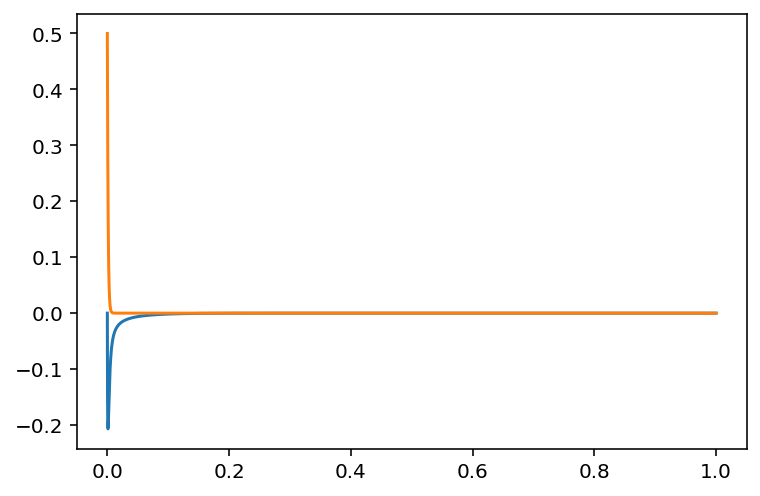

error of decompose 1.0277640915483067e-10
len of gamma 4


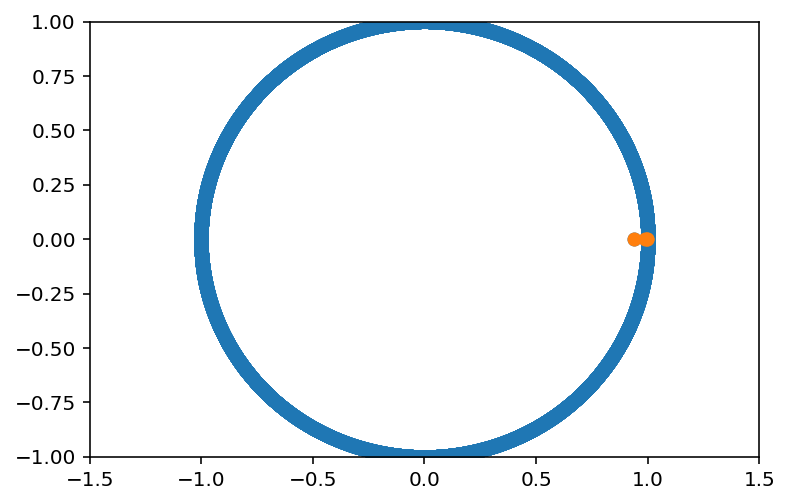

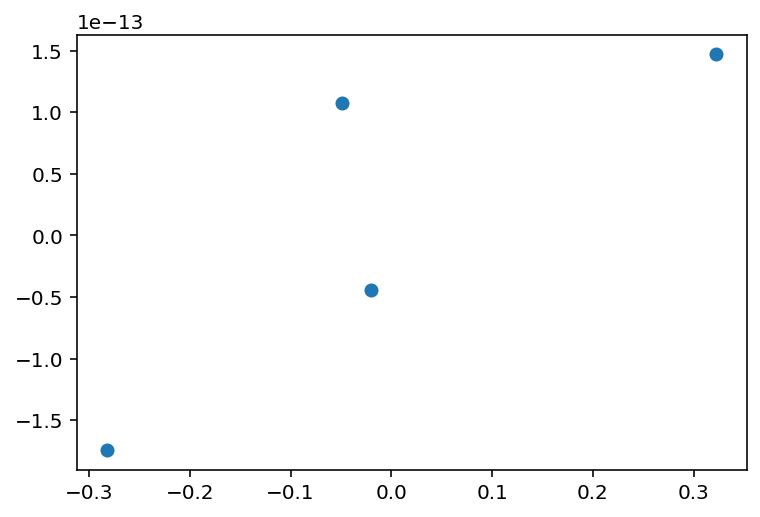

In [7]:
n = 15000
scale = 800
n_gamma = 4

n_sample = n + 1
t = np.linspace(0, 1, 2 * n + 1)
res_t = np.zeros(len(t), dtype=complex)
fit_t(scale * t, res_t, expn_pade1, etal_pade1)
plt.plot(t, np.imag(res_t))
plt.plot(t, np.real(res_t))
plt.show()
h = np.imag(res_t)
H = np.zeros((n_sample, n_sample))
for i in range(n_sample):
    H[i, :] = h[i:n_sample + i]
sing_vs, Q = LA.eigh(H)
phase_mat = np.diag(
    [np.exp(-1j * np.angle(sing_v) / 2.0) for sing_v in sing_vs])
vs = np.array([np.abs(sing_v) for sing_v in sing_vs])
Qp = np.dot(Q, phase_mat)
sort_array = np.argsort(vs)[::-1]
vs = vs[sort_array]
Qp = (Qp[:, sort_array])
print(
    "error of decompose",
    np.sum(np.abs(H -
                  np.dot(np.dot(Qp, np.diag(vs)), (np.transpose(Qp))))))

print("len of gamma", n_gamma)
gamma = np.roots(Qp[:,n_gamma][::-1])
gamma_new = gamma[np.argsort(np.abs(gamma))[:n_gamma]]
t_new = 2*n*np.log(gamma_new)
plt.scatter(np.real(gamma),np.imag(gamma))
plt.scatter(np.real(gamma_new),np.imag(gamma_new))
plt.xlim(-1.5,1.5)
plt.ylim(-1,1)
plt.show()
gamma_m = np.zeros((n_sample*2-1, n_gamma), dtype=complex)
for i in range(n_gamma):
    for j in range(n_sample*2-1):
        gamma_m[j,i] = gamma_new[i]**j
omega_new = np.dot(LA.inv(np.dot(np.transpose(gamma_m), gamma_m)), np.dot(np.transpose(gamma_m), np.transpose(h)))
plt.scatter(np.real(omega_new),np.imag(omega_new))
plt.show()

In [9]:
etal1 = 1.j * omega_new
etar1 = np.conjugate(1.j * omega_new)
etaa1 = np.abs(omega_new)
expn1 = -t_new / scale
etal_real1, etar_real1, etaa_real1, expn_real1 = decompose_spe_real(
    phixx_sp, sp_para_dict, para_dict1, condition_dict, 1)

etal1 = np.append(etal1, etal_real1)
etar1 = np.append(etar1, etar_real1)
etaa1 = np.append(etaa1, etaa_real1)
expn1 = np.append(expn1, expn_real1)

# etal1 = np.append(etal1, etal_pade1[0])
# etar1 = np.append(etar1, etar_pade1[0])
# etaa1 = np.append(etaa1, etaa_pade1[0])
# expn1 = np.append(expn1, expn_pade1[0])

fermi_path = "../PFS/fermi-1-1/f-{}-comp/"
for npfs, beta in itertools.product([10], [100]):
    if os.path.exists((fermi_path + "etal1_{}").format(beta, npfs-1)):
        etal_prony1 = np.loadtxt((fermi_path + "etal1_{}").format(beta, npfs-1), dtype=complex)
    if os.path.exists((fermi_path + "expn1_{}").format(beta, npfs-1)):
        expn_prony1 = np.loadtxt((fermi_path + "expn1_{}").format(beta, npfs-1), dtype=complex)
    if os.path.exists((fermi_path + "etal2_{}").format(beta, npfs-1)):
        etal_prony2 = np.loadtxt((fermi_path + "etal2_{}").format(beta, npfs-1), dtype=complex)
    if os.path.exists((fermi_path + "expn2_{}").format(beta, npfs-1)):
        expn_prony2 = np.loadtxt((fermi_path + "expn2_{}").format(beta, npfs-1), dtype=complex)
        
# len_ = 10000
# spe_wid = 6

# w_origin = np.array([
#     -(np.linspace(0, spe_wid, len_))[::-1] - 0.5,
#     np.linspace(-0.5, 0.5, len_),
#     np.linspace(0, spe_wid, len_) + 0.5
# ]).flatten()
# w = np.array([
#     -10**(np.linspace(0, spe_wid, len_))[::-1],
#     np.linspace(-1, 1, len_), 10**np.linspace(0, spe_wid, len_)
# ]).flatten()

# w_sp, lamd_sp, gams_sp, beta_sp = sp.symbols(
#     r"\omega , \lambda, \gamma, \beta", real=True)

len_ = 100000
spe_wid = 20
w = np.linspace(-spe_wid, spe_wid, len_)
phixx = lams1 * gams1**2 / ((
    (w - mu_x) - omgs1)**2 + gams1**2) / (1 + np.exp(beta * (w - mu_x)))
res_J1 = np.zeros(len(w), dtype=complex)
res_J1_10 = np.zeros(len(w), dtype=complex)
fit_J(w, res_J1, expn1, etal1, 1)
fit_J(w, res_J1_10, expn_prony1, etal_prony1, 1)
res_J1_pade_d = {}
for npsd in [5, 10, 15]:
    etal_pade1 = etal_pade_d[npsd]
    expn_pade1 = expn_pade_d[npsd]
    res_J1_pade = np.zeros(len(w), dtype=complex)
    fit_J(w, res_J1_pade, expn_pade1, etal_pade1, 1)
    res_J1_pade_d[npsd] = res_J1_pade

[-1.0*I, 1.0*I]


/home/dhem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in exp
